# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.utils import to_categorical

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from art.utils import load_mnist
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import NewtonFool

# Load Data

In [2]:
(x_train, y_train), (x_test, y_test), min_, max_ = load_mnist()

In [3]:
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

n_samples_max = 100
x_train = x_train[:n_samples_max]
y_train = y_train[:n_samples_max]
x_test = x_test[:n_samples_max]
y_test = y_test[:n_samples_max]

# Model

In [17]:
model = models.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [18]:
model.compile(loss=SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=["accuracy"])

# Train

In [19]:
model.fit(x_train, y_train, epochs=10, batch_size=32)

Epoch 1/10


/home/alper/.local/lib/python3.10/site-packages/keras/src/backend.py:5714: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


4/4 [==============================] - 1s 7ms/step - loss: 2.2569 - accuracy: 0.1700
Epoch 2/10
4/4 [==============================] - 0s 7ms/step - loss: 1.9526 - accuracy: 0.4600
Epoch 3/10
4/4 [==============================] - 0s 7ms/step - loss: 1.6897 - accuracy: 0.5600
Epoch 4/10
4/4 [==============================] - 0s 7ms/step - loss: 1.3962 - accuracy: 0.7300
Epoch 5/10
4/4 [==============================] - 0s 7ms/step - loss: 1.0998 - accuracy: 0.8200
Epoch 6/10
4/4 [==============================] - 0s 7ms/step - loss: 0.8421 - accuracy: 0.8900
Epoch 7/10
4/4 [==============================] - 0s 7ms/step - loss: 0.5927 - accuracy: 0.9500
Epoch 8/10
4/4 [==============================] - 0s 7ms/step - loss: 0.4095 - accuracy: 0.9600
Epoch 9/10
4/4 [==============================] - 0s 6ms/step - loss: 0.2689 - accuracy: 0.9700
Epoch 10/10
4/4 [==============================] - 0s 6ms/step - loss: 0.1666 - accuracy: 1.0000


# Attack

In [20]:
art_model = TensorFlowV2Classifier(model=model, loss_object=SparseCategoricalCrossentropy(from_logits=True), nb_classes=10, input_shape=(784,), clip_values=(0, 1))

In [21]:
deep_fool = NewtonFool(classifier=art_model)

In [22]:
adv_test = deep_fool.generate(x=x_test)

NewtonFool:   0%|          | 0/100 [00:00<?, ?it/s]

# Results

In [23]:
safe_preds = np.argmax(art_model.predict(x_test), axis=1)

In [24]:
safe_model_scores = {
    'ACC': accuracy_score(y_test, safe_preds),
    'PREC': precision_score(y_test, safe_preds, average='weighted'),
    'REC': recall_score(y_test, safe_preds, average='weighted'),
    'F1': f1_score(y_test, safe_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
safe_model_scores

{'ACC': 0.7, 'PREC': 0.7421744595274007, 'REC': 0.7, 'F1': 0.6895230414746543}

In [26]:
adv_preds = np.argmax(art_model.predict(adv_test), axis=1)

In [27]:
adv_model_scores = {
    'ACC': accuracy_score(y_test, adv_preds),
    'PREC': precision_score(y_test, adv_preds, average='weighted'),
    'REC': recall_score(y_test, adv_preds, average='weighted'),
    'F1': f1_score(y_test, adv_preds, average='weighted')
}

/home/alper/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
adv_model_scores

{'ACC': 0.35,
 'PREC': 0.42544390913745755,
 'REC': 0.35,
 'F1': 0.3400204670245238}

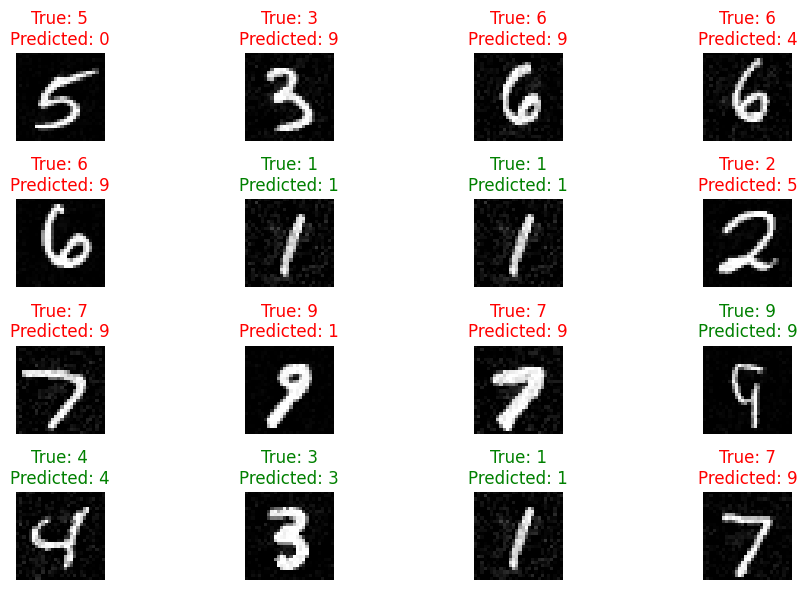

In [29]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(10, 6))
random_index = np.random.randint(0, len(adv_test), 16)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(adv_test[random_index[i]].reshape(28, 28), cmap='gray')
    ax.axis('off')

    if y_test[random_index[i]] == adv_preds[random_index[i]]:
        color = 'green'
    else:
        color = 'red'

    ax.set_title(
        f'True: {y_test[random_index[i]]}\nPredicted: {adv_preds[random_index[i]]}',
        color=color
    )

plt.tight_layout()
plt.show()